In [2]:
import sys
import os
import networkx as nx
from sympy import *
from bond_graph import *
# from bond_graph_nodes import *
from scipy import *
import time
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

# Half-Car Suspension Simulation

Simulator for a half car suspension shown in the following model:

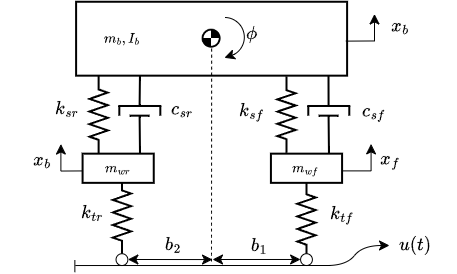

### Set suspension parameters 

In [3]:
t_span = [0, 5]
t = np.linspace(t_span[0], t_span[1], 500)

# Fixed Parameters
m_b = 1794.0
I = 3443.05
m_wf = 87.15
m_wr = 140.04

k_tf = 155900.0
k_tr = 200000.0

b1 = 1.271
b2 = 1.713

# Nominal Design Parameters
C_sf = 1190
C_sr = 1000
k_sf = 66824
k_sr = 18615


# Optimization Ranges
C_sf_min = 1000
C_sr_min = 1000
k_sf_min = 10000
k_sr_min = 10000 

C_sf_max = 2500
C_sr_max = 2500
k_sf_max = 70000
k_sr_max = 70000


### Speed Bump Forcing Function
Delayed step input to the front and rear tire as a function of the speed

In [4]:
def speed_bump_excitation(t):
    H = 0.075
    L = 0.5
    KPH_to_MPS = 1.0/3.6
    v = 10 * KPH_to_MPS

    if t >= 0:
        # y1 = -(H/2)*(np.cos(2*np.pi*v*t/L)-1), 
        # return (np.pi*H*v/L)*(np.sin(2*np.pi*v*t/L))
        # return 0.0
        y1 = 0.1
    else:
        y1 = 0.0
    
    # if t >= v/(b1+b2):
    if t >= 0.1:
        y2 = 0.1
    else:
        y2 = 0.0

    return np.array([y1, y2])



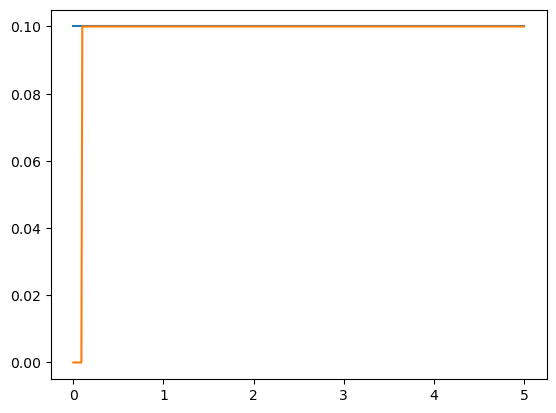

In [5]:
# Visualization of Speed Bump Forcing Function
u = np.array(list(speed_bump_excitation(t_i) for t_i in t))
# print(u)
plt.plot(t,u[:,0])
plt.plot(t, u[:,1])
plt.show()

### Define the Half-Car Dynamics ODE And Solve

In [6]:

# x0 = np.zeros(len(G.get_energy_storage_elements())) # Initial conditions
x0 = np.zeros(8)
# print(len(np.array([0, 0])))
# u = lambda t: [0]
# G.dynamics(x0 , 1, u)

## Generate a forcing input at 5 hertz
u = lambda t: speed_bump_excitation(t)
# u = lambda t: 0


def half_car_dynamics(z, t, u):
    xf = z[0]
    xf_dot = z[1]
    xr = z[2]
    xr_dot = z[3]
    phi = z[4]
    phi_dot = z[5]
    xb = z[6]
    xb_dot = z[7]
    
    xf_ddot = (1/m_wf)*(-C_sf*(xf_dot+b1*phi_dot-xb_dot) - k_sf*(xf+b1*phi-xb) - k_tf*xf + k_tf*u(t)[0])
    xr_ddot = (1/m_wr)*(-C_sr*(xr_dot+b2*phi_dot-xb_dot) - k_sr*(xr-b2*phi-xb) - k_tr*xr + k_tr*u(t)[1])
    phi_ddot = (1/I)*(-C_sf*b1*(b1*phi_dot+xf_dot-xb_dot) - C_sr*b2*(b2*phi_dot-xr_dot+xb_dot) - k_sf*b1*(b1*phi+xf-xb) - k_sr*b2*(b2*phi-xr+xb))
    xb_ddot = (1/m_b)*(-C_sf*(xb_dot-b1*phi_dot-xf_dot) - C_sr*(xb_dot+b2*phi_dot-xr_dot) - k_sf*(xb-b1*phi-xf) - k_sr*(xb+b2*phi-xr))
    
    return[xf_dot, xf_ddot, xr_dot, xr_ddot, phi_dot, phi_ddot, xb_dot, xb_ddot]

z = integrate.odeint(half_car_dynamics, np.array(x0), t, args=(u,))







### Plots

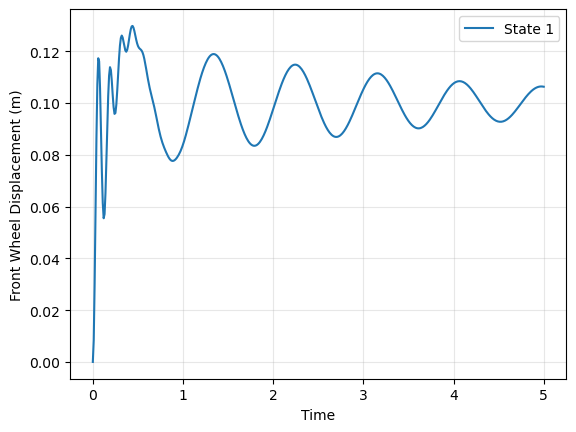

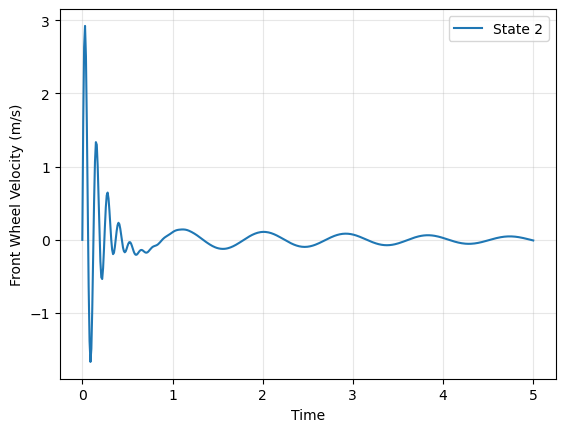

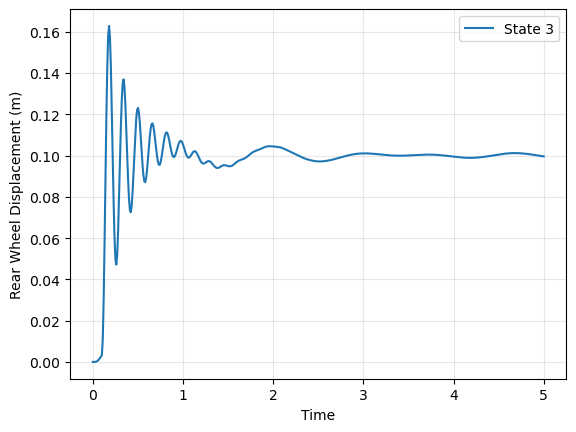

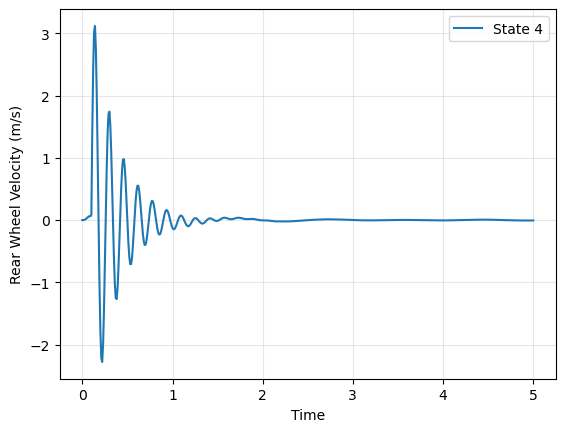

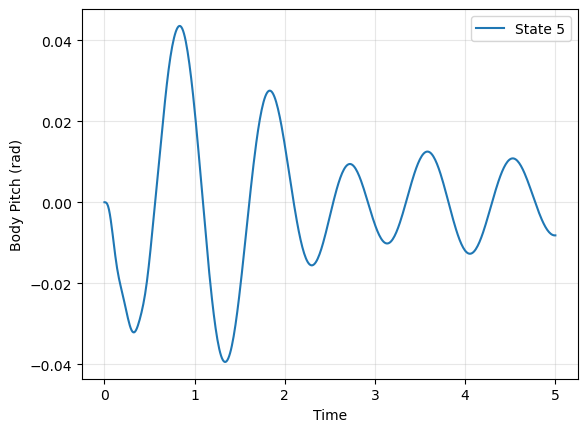

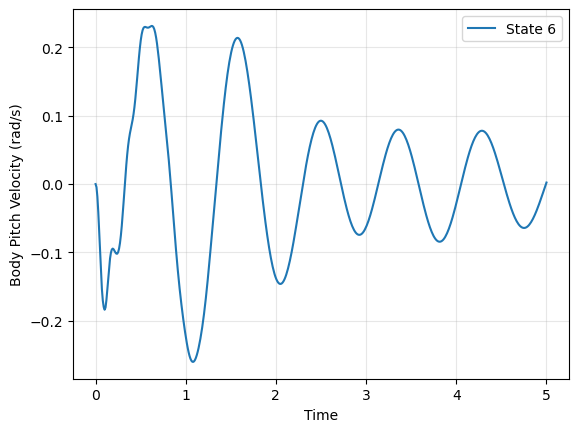

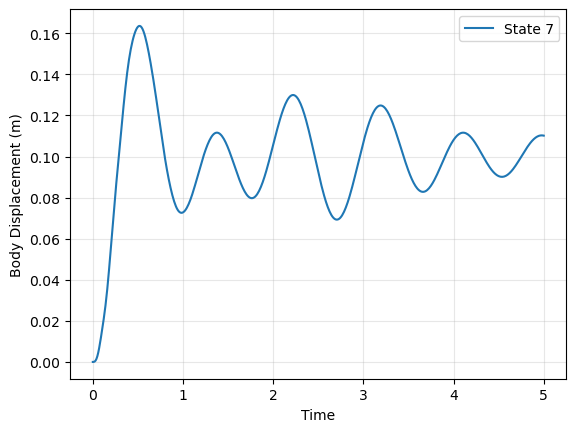

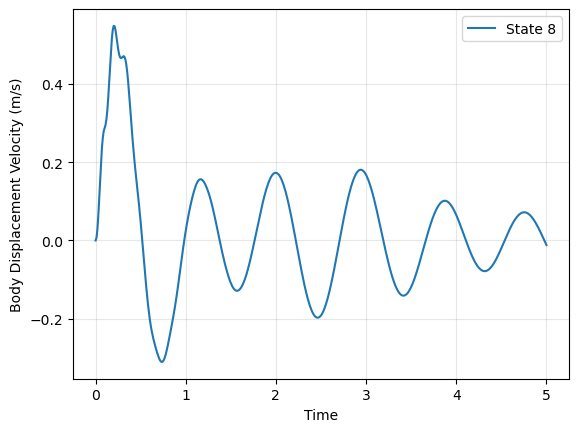

In [7]:
import matplotlib.pyplot as plt

# Assuming `z` is the array containing the time series data
var_names = ["Front Wheel Displacement (m)", "Front Wheel Velocity (m/s)", "Rear Wheel Displacement (m)", "Rear Wheel Velocity (m/s)", "Body Pitch (rad)", "Body Pitch Velocity (rad/s)", "Body Displacement (m)", "Body Displacement Velocity (m/s)"]
# Plot the first 4 time series
for i in range(8):
    plt.plot(t, z[:,i], label=f"State {i+1}")
    plt.xlabel("Time")
    plt.ylabel(var_names[i])
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
        

